# Increasing precision
## data augmentation
- flip
- move
- blur
- brighten/darken

## network
hyperparam opt - nb Couches conv, taille filtres

## decrease false positive
increase weight of negatives

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot


ModuleNotFoundError: No module named 'pyplot'

In [3]:
home = "C:/Users/JB/Desktop/INSA/5IF/ML/face_detection/dataset/start_deep/"

## Loading data

In [4]:
df = pd.read_csv("dataset/start_deep/posneg.txt", sep=" ", names=["filename", "class"])
df = df.astype(str)
df.head()

,filename,class
0,1/Image000605.pgm,1
1,1/Image000607.pgm,1
2,1/Image000608.pgm,1
3,1/Image000609.pgm,1
4,1/Image000610.pgm,1


In [5]:
df_test = pd.read_csv("dataset/start_deep/testposneg.txt", sep=" ", names=["filename", "class"])
df_test = df_test.astype(str)
df_test.head()

,filename,class
0,"test_images/googlefaces_test/503_1__t0,0_r0_s1...",1
1,"test_images/googlefaces_test/367_0__t0,0_r0_s1...",1
2,"test_images/googlefaces_test/10_0__t0,0_r0_s1.pgm",1
3,"test_images/googlefaces_test/53_0__t0,0_r0_s1.pgm",1
4,"test_images/googlefaces_test/323_0__t0,0_r0_s1...",1


In [6]:
# Changing files from pgm to jpg - run only once
# from PIL import Image
# for file in df_test["filename"]:
#     abs_path = home+file
#     img = Image.open(abs_path)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     if new_name != abs_path:
#         img.save(new_name)

In [7]:
# from PIL import Image
# for file in df["filename"]:
#     abs_path = home+"train_images/" + file
#     img = Image.open(home+"train_images/" + file)
#     new_name = abs_path.replace(".pgm", ".jpg")
#     img.save(new_name)

In [8]:
# renaming .pgm to jpg
def replace_name(name):
    return name.replace(".pgm", ".jpg")
df["filename"] = df["filename"].apply(replace_name)
df_test["filename"] = df_test["filename"].apply(replace_name)

In [9]:
df.head()

,filename,class
0,1/Image000605.jpg,1
1,1/Image000607.jpg,1
2,1/Image000608.jpg,1
3,1/Image000609.jpg,1
4,1/Image000610.jpg,1


### Split train and validation

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df)

In [11]:
root_dir = home+"train_images/"

In [12]:
from PIL import Image
img = Image.open(root_dir+df["filename"][0])
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
IMG_HEIGHT, IMG_WIDTH

(36, 36)

### Creating generators

In [115]:
batch_size=32
train_image_generator = ImageDataGenerator(rescale=1./255,
#                                                   vertical_flip=True,
                                                          width_shift_range=[-4,4],
                                                          height_shift_range=[-4,4],
                                                          horizontal_flip=True,
#                                                           rotation_range=5,
                                                          brightness_range=[0.8,1.0]
                                            )
train_data_gen = train_image_generator.flow_from_dataframe(df_train, 
                                                           directory=root_dir,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 68790 validated image filenames belonging to 2 classes.


In [116]:
batch_size=32
val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_dataframe(df_val, 
                                                           directory=root_dir,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 22930 validated image filenames belonging to 2 classes.


In [117]:
test_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_generator.flow_from_dataframe(df_test, 
                                                           directory=home,
                                                          color_mode="grayscale", x_col="filename", y_col="class",
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size,
                                                          class_mode="binary",
                                                          shuffle=True)

Found 7628 validated image filenames belonging to 2 classes.


In [118]:
sample_training_images, _ = next(train_data_gen)

In [119]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

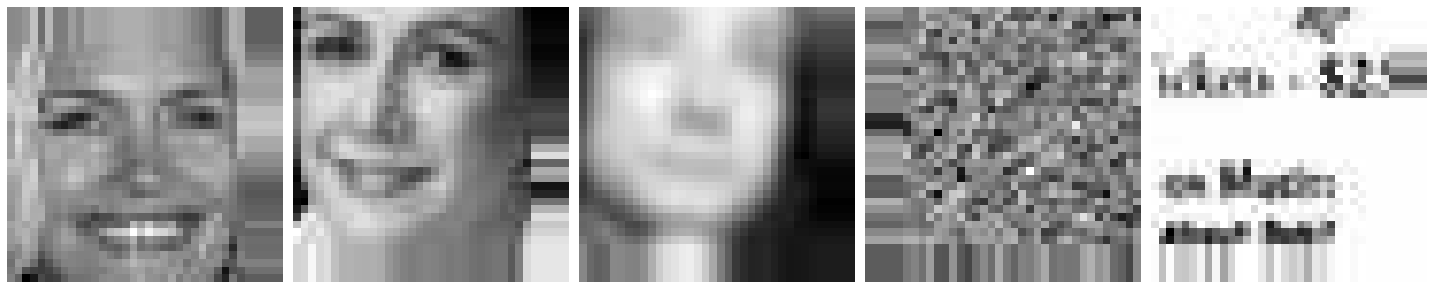

In [120]:
plotImages(sample_training_images[:5])

In [121]:
dropout_rate = 0.3
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(dropout_rate),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

In [122]:
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    auc = tf.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

model.compile(optimizer='adam',
              loss="binary_crossentropy", 
             metrics=["accuracy","AUC"])

In [123]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 36, 36, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 64)         

In [124]:
epochs = 5
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=None,
    epochs=epochs,
    validation_data=val_data_gen,
#     validation_steps=len(df) // batch_size
)

Epoch 1/5
2150/2150 [==============================] - 198s 92ms/step - loss: 0.1949 - accuracy: 0.9204 - AUC: 0.9693 - val_loss: 0.1058 - val_accuracy: 0.9590 - val_AUC: 0.9935
Epoch 2/5
2150/2150 [==============================] - 195s 91ms/step - loss: 0.0643 - accuracy: 0.9760 - AUC: 0.9965 - val_loss: 0.0744 - val_accuracy: 0.9703 - val_AUC: 0.9980
Epoch 3/5
2150/2150 [==============================] - 196s 91ms/step - loss: 0.0390 - accuracy: 0.9857 - AUC: 0.9985 - val_loss: 0.0465 - val_accuracy: 0.9825 - val_AUC: 0.9986
Epoch 4/5
2150/2150 [==============================] - 197s 92ms/step - loss: 0.0339 - accuracy: 0.9877 - AUC: 0.9986 - val_loss: 0.0379 - val_accuracy: 0.9866 - val_AUC: 0.9990
Epoch 5/5
2150/2150 [==============================] - 207s 96ms/step - loss: 0.0283 - accuracy: 0.9895 - AUC: 0.9991 - val_loss: 0.0281 - val_accuracy: 0.9904 - val_AUC: 0.9993


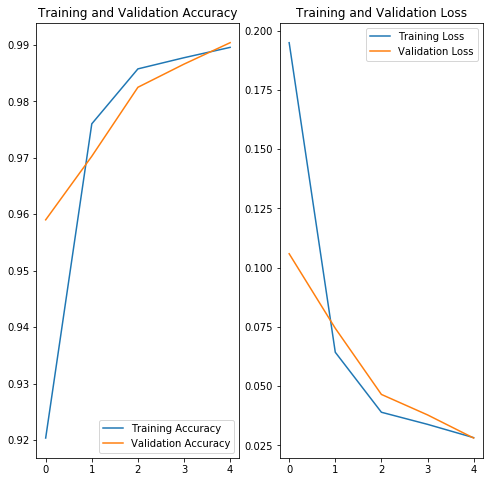

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Metrics

In [126]:
truth = val_data_gen.labels
prediction = model.predict_generator(val_data_gen)

In [127]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(roc_auc_score(truth, prediction))
print(accuracy_score(truth, np.round(prediction)))

0.4987286287217927
0.589664195377235


In [128]:
next_batch = next(val_data_gen)
roc_auc_score(next_batch[1], model.predict(next_batch))

1.0

In [129]:
model.evaluate_generator(test_data_gen)

[0.0422026319823824, 0.98833245, 0.9972152]